In [2]:
import numpy as np
import keras
import pickle
import os
import sklearn
import pandas as pd
import time 
import matplotlib.pyplot as plt

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.layers import CuDNNLSTM
from keras.models import Sequential
from sklearn import preprocessing

import util.preprocessing as pphelper
import importlib
importlib.reload(pphelper) #reloading own helper often, it's still changing during writing

Using TensorFlow backend.


<module 'util.preprocessing' from '/home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/util/preprocessing.py'>

## Learning to forecast the demand of customers. 

From code docs
```
let's  check if this is worth adding. if so, we add the input to list0 and the result to list1                                                          
[0,5]  customer_metadata                                                                                                                                
[6,10] rate_metadata                                                                                                                                    
[11]   consume_now      
```

In [14]:
os.getcwd()

'/home/pascalwhoop/Documents/Code/University/powerTAC/python-agent'

In [15]:
consume_files_path = os.path.abspath(os.path.join(os.getcwd(), "data/consume"))

In [16]:
files = os.listdir(consume_files_path)

files.sort()
files

['game0labels.pickle',
 'game0training.pickle',
 'game10labels.pickle',
 'game10training.pickle',
 'game11labels.pickle',
 'game11training.pickle',
 'game12labels.pickle',
 'game12training.pickle',
 'game13labels.pickle',
 'game13training.pickle',
 'game14labels.pickle',
 'game14training.pickle',
 'game15labels.pickle',
 'game15training.pickle',
 'game16labels.pickle',
 'game16training.pickle',
 'game17labels.pickle',
 'game17training.pickle',
 'game18labels.pickle',
 'game18training.pickle',
 'game19labels.pickle',
 'game19training.pickle',
 'game1labels.pickle',
 'game1training.pickle',
 'game20labels.pickle',
 'game20training.pickle',
 'game21labels.pickle',
 'game21training.pickle',
 'game22labels.pickle',
 'game22training.pickle',
 'game23labels.pickle',
 'game23training.pickle',
 'game24labels.pickle',
 'game24training.pickle',
 'game25labels.pickle',
 'game25training.pickle',
 'game26labels.pickle',
 'game26training.pickle',
 'game27labels.pickle',
 'game27training.pickle',
 'ga

In [18]:
def get_game_data(train_path, label_path):
    print("getting {}".format(train_path))
    with open(label_path, "rb") as fh:
        labels        = pickle.load(fh)
    with open(train_path, "rb") as fh:
        training_data = pickle.load(fh)
    return [np.array(training_data), np.array(labels)]

_train = os.path.join(consume_files_path, files[1])
_labels = os.path.join(consume_files_path, files[0])

_game_data = get_game_data(_train, _labels)
_game_data[0].shape

getting /home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/data/consume/game0training.pickle


(200, 1453, 18)

Alright the data seems to check out. Let's get the whole baby shall we. But not like before, it's too large all at once. An iterator is a better idea

In [7]:
from typing import List


#print(files_full_paths)

class GamesIterator:
    def __init__(self):
        fp = []
        for index in range(int(len(files)/2)):
            labels_path = os.path.join(consume_files_path, files[index*2])
            training_path = os.path.join(consume_files_path, files[index*2+1])
            fp.append([training_path, labels_path])
        self.file_paths = fp
        
    def __iter__(self):
        return self

    def __next__(self): # Python 3: def __next__(self)
        
        p = self.file_paths.pop()
        return get_game_data(p[0], p[1])

count = 0
for game in GamesIterator():
    count += 1
    print(game[1].shape)
    if count > 0:
        break


getting /home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/data/consume/game9training.pickle
(199, 1569)


Alright. The iterator is set. We can get a list of games and for each game run some training. Let's do that. Time to finally do some data science

In [52]:
game_data = next(GamesIterator())
usage_data = game_data[1]

getting /home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/data/consume/game9training.pickle


In [45]:
usage_data = np.array(usage_data)
usage_data.shape

(199, 1569)

Let's look at some of the usage data. Plotting the usage of different subgroups (of customers and time)

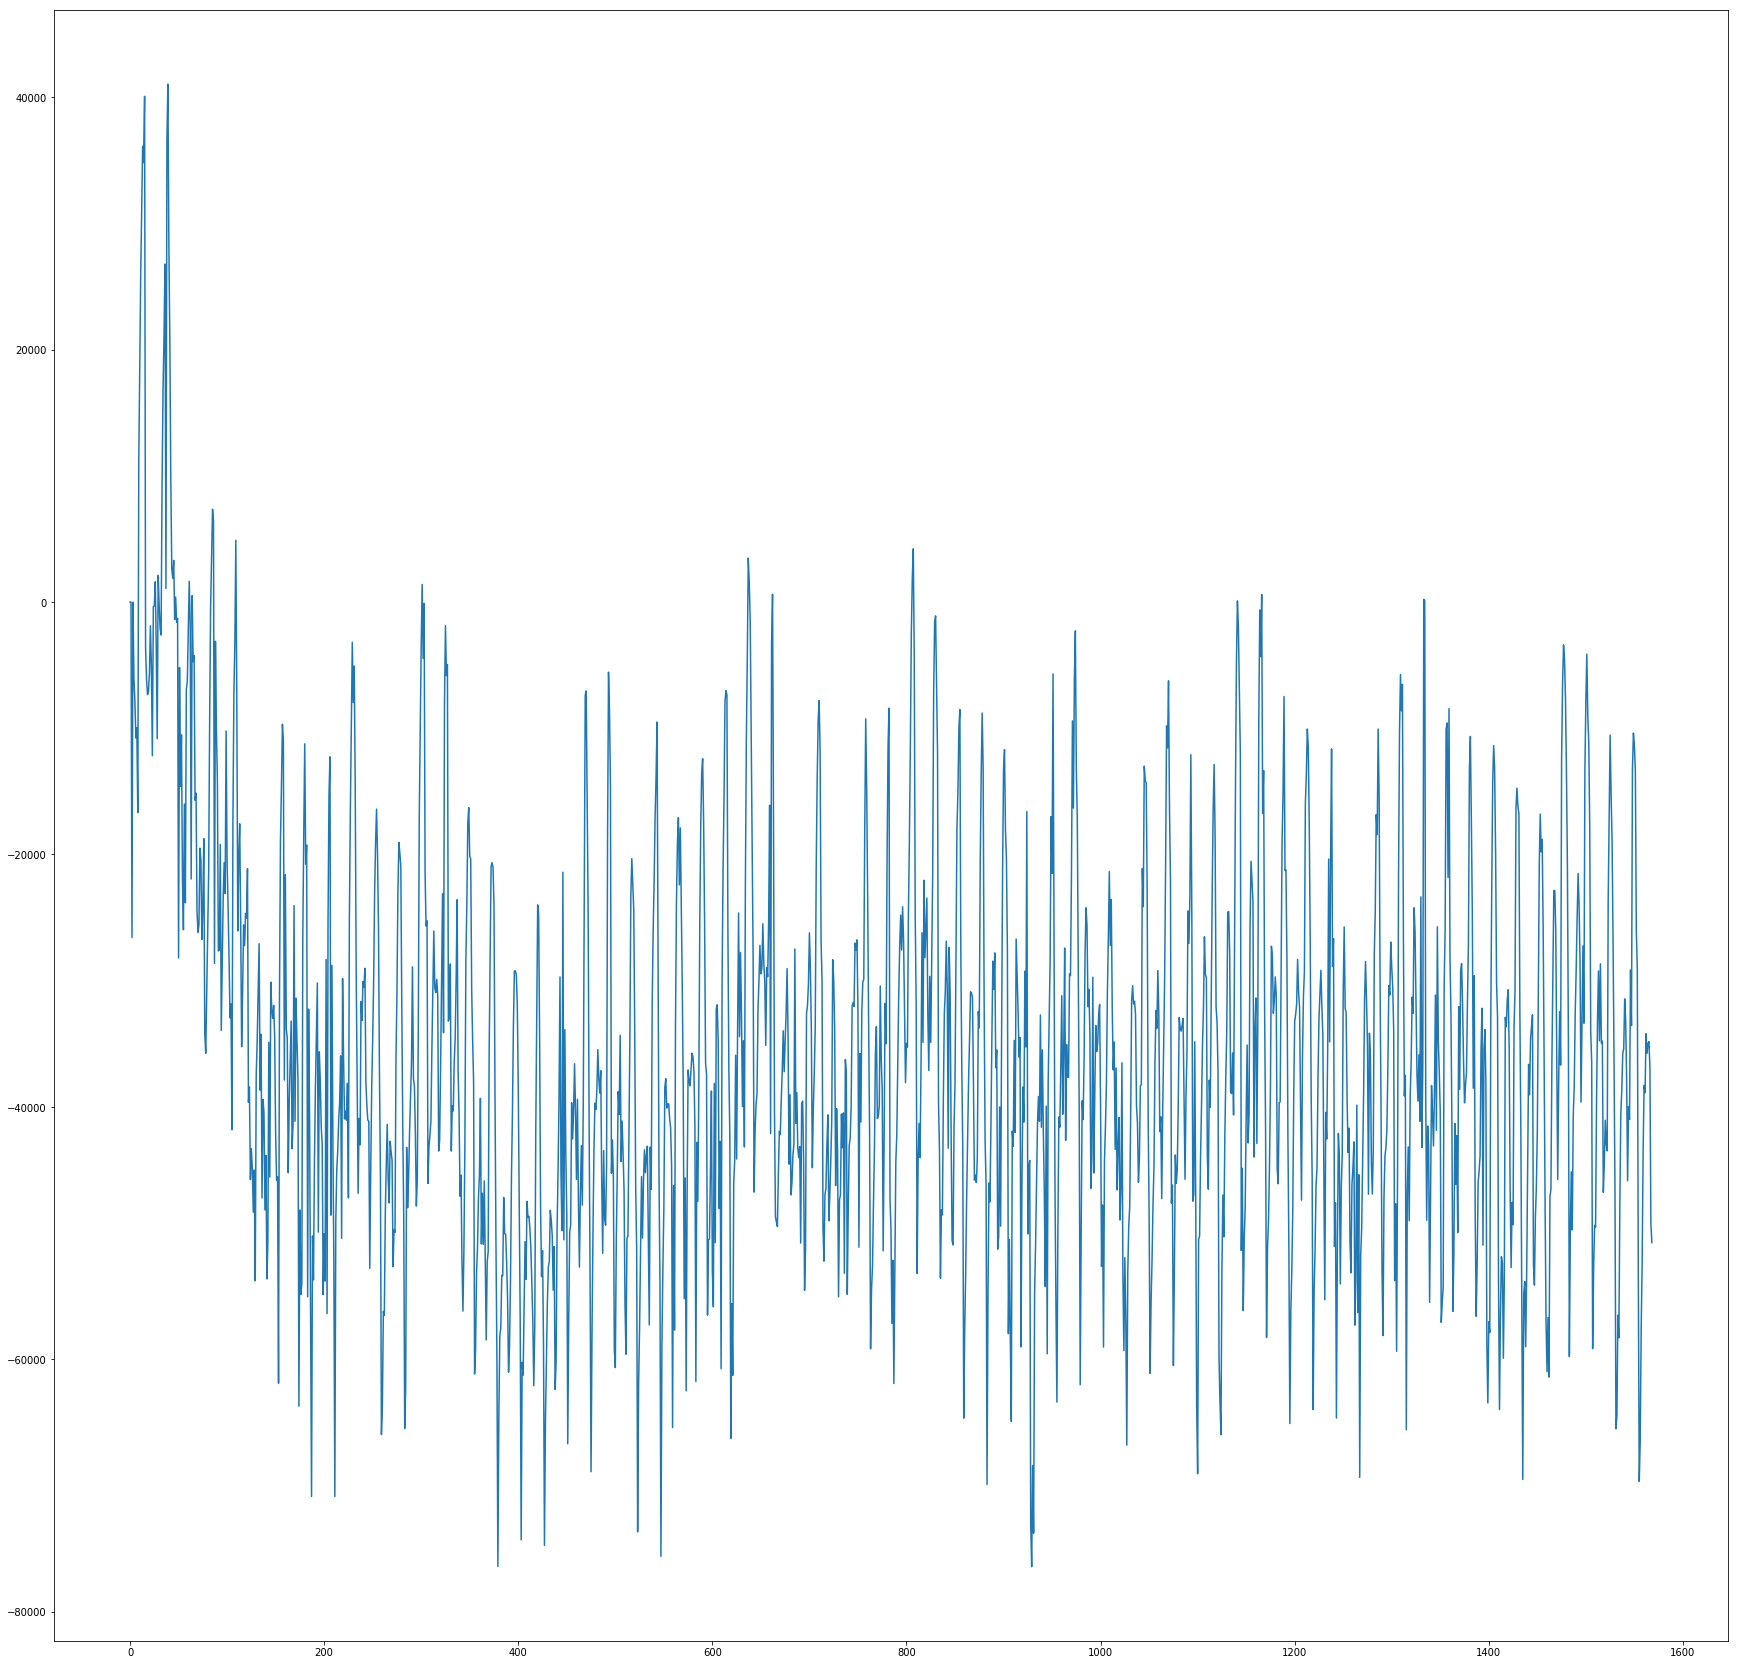

In [12]:
summed_data = usage_data.sum(axis=0)
ts = pd.Series(summed_data, index=range(len(summed_data)))
ts.plot(figsize=(30,30))


Okay, not much to see here. There are spikes and drops, they probably correlate with days and nights. There is an initial production bump at the first few steps and then a consistent undersupply of energy (i.e. the external suppliers kick in)

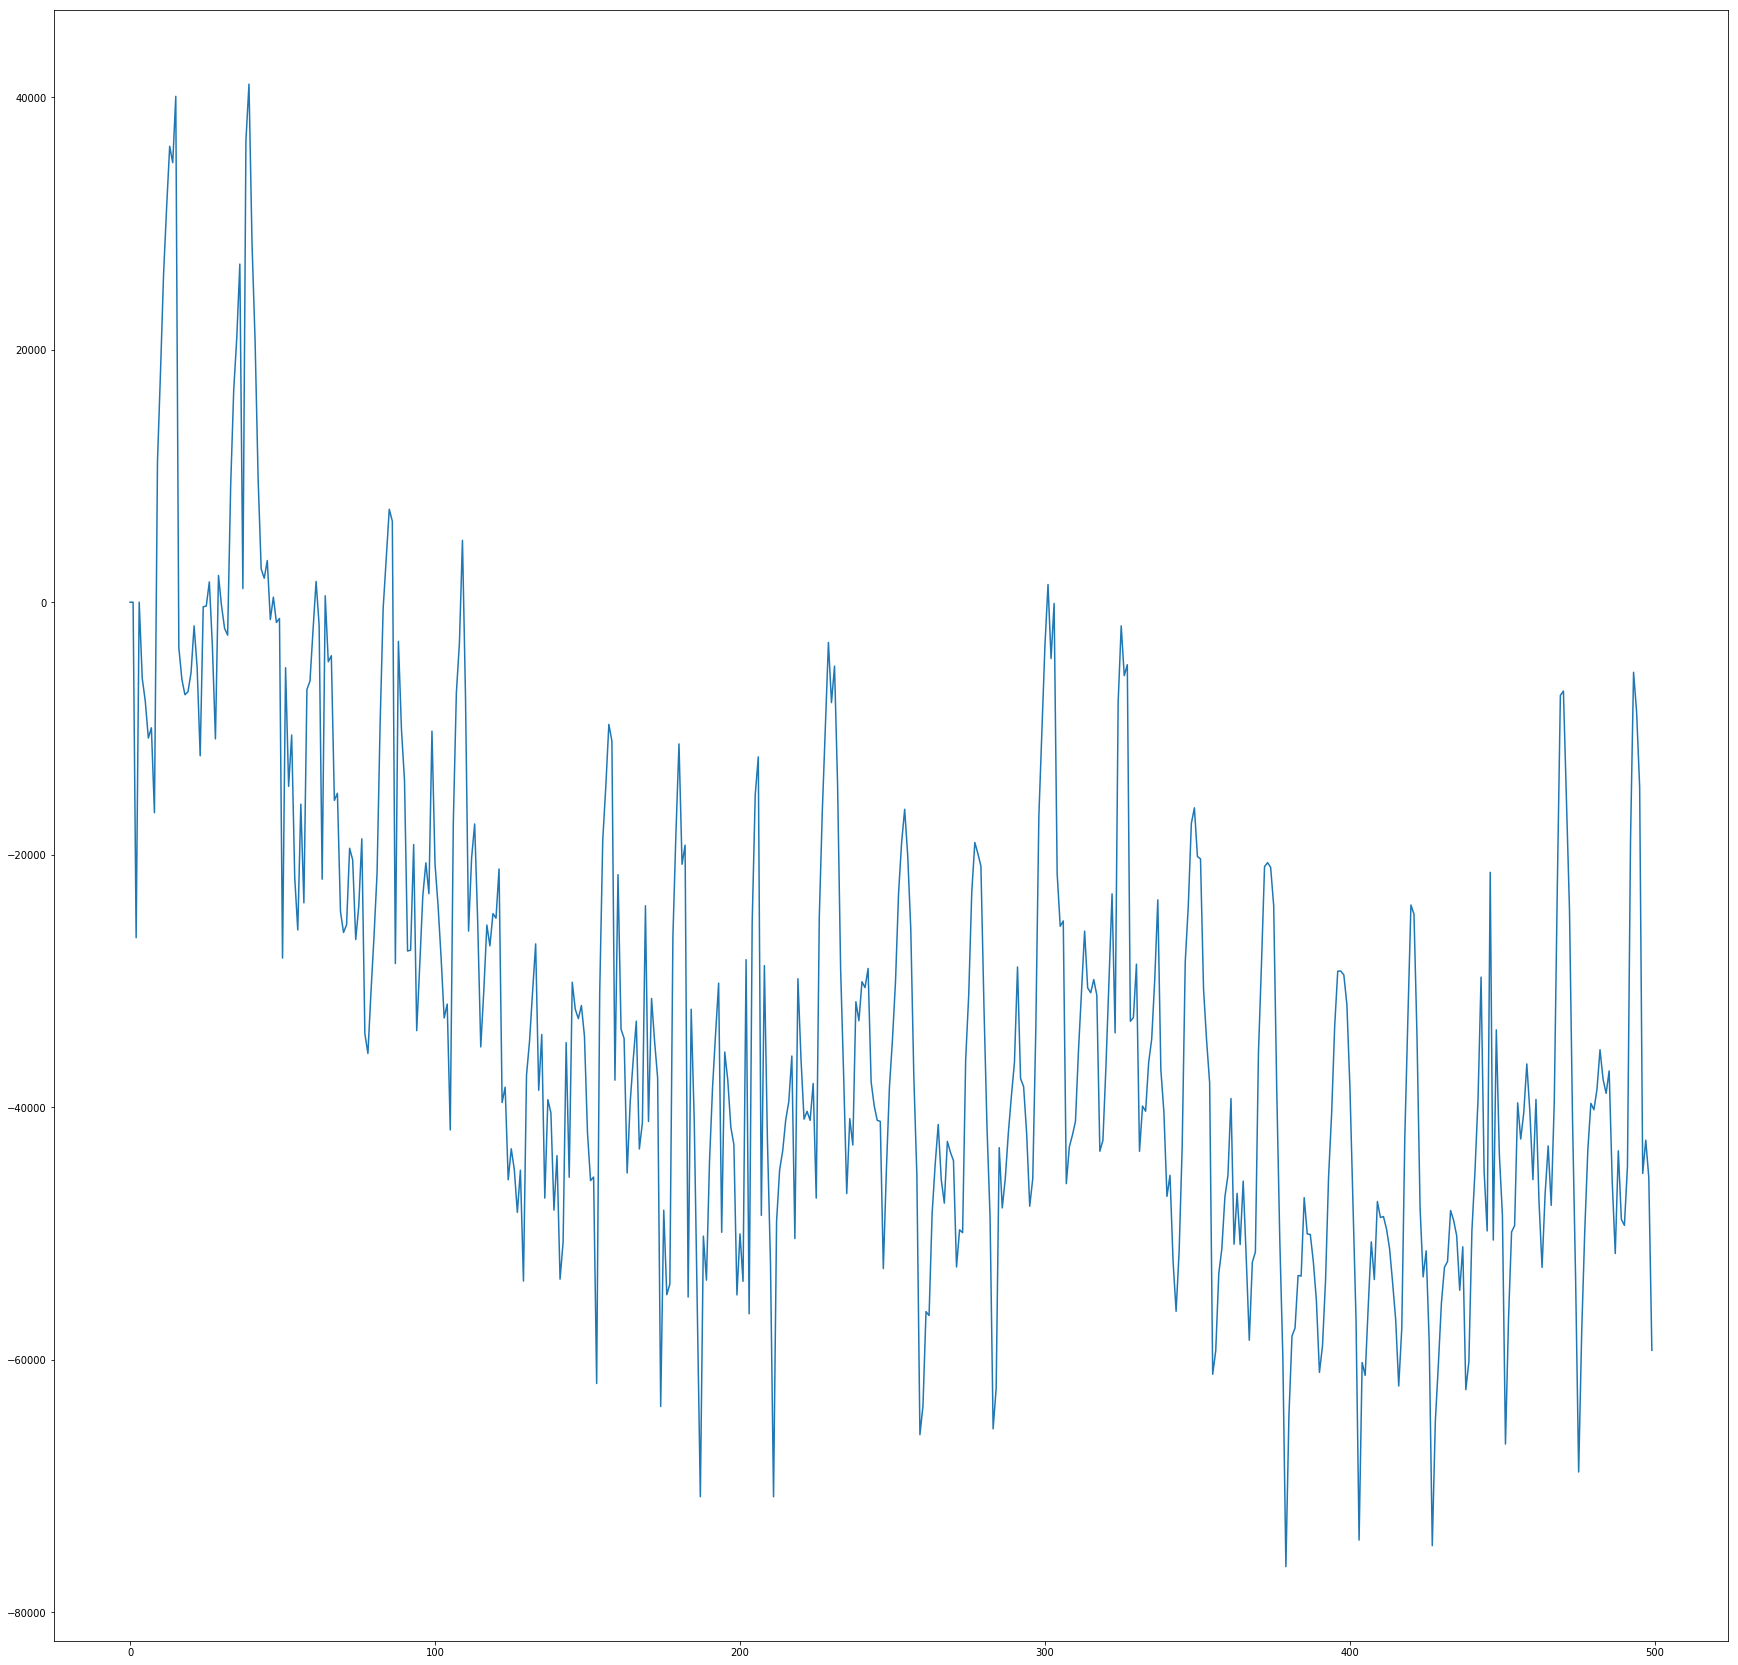

In [13]:
summed_data = usage_data[:,:500].sum(axis=0)
ts = pd.Series(summed_data, index=range(len(summed_data)))
ts.plot(figsize=(30,30))


So it's easier to see the up and down of usage during different days. Let's look at just one customer

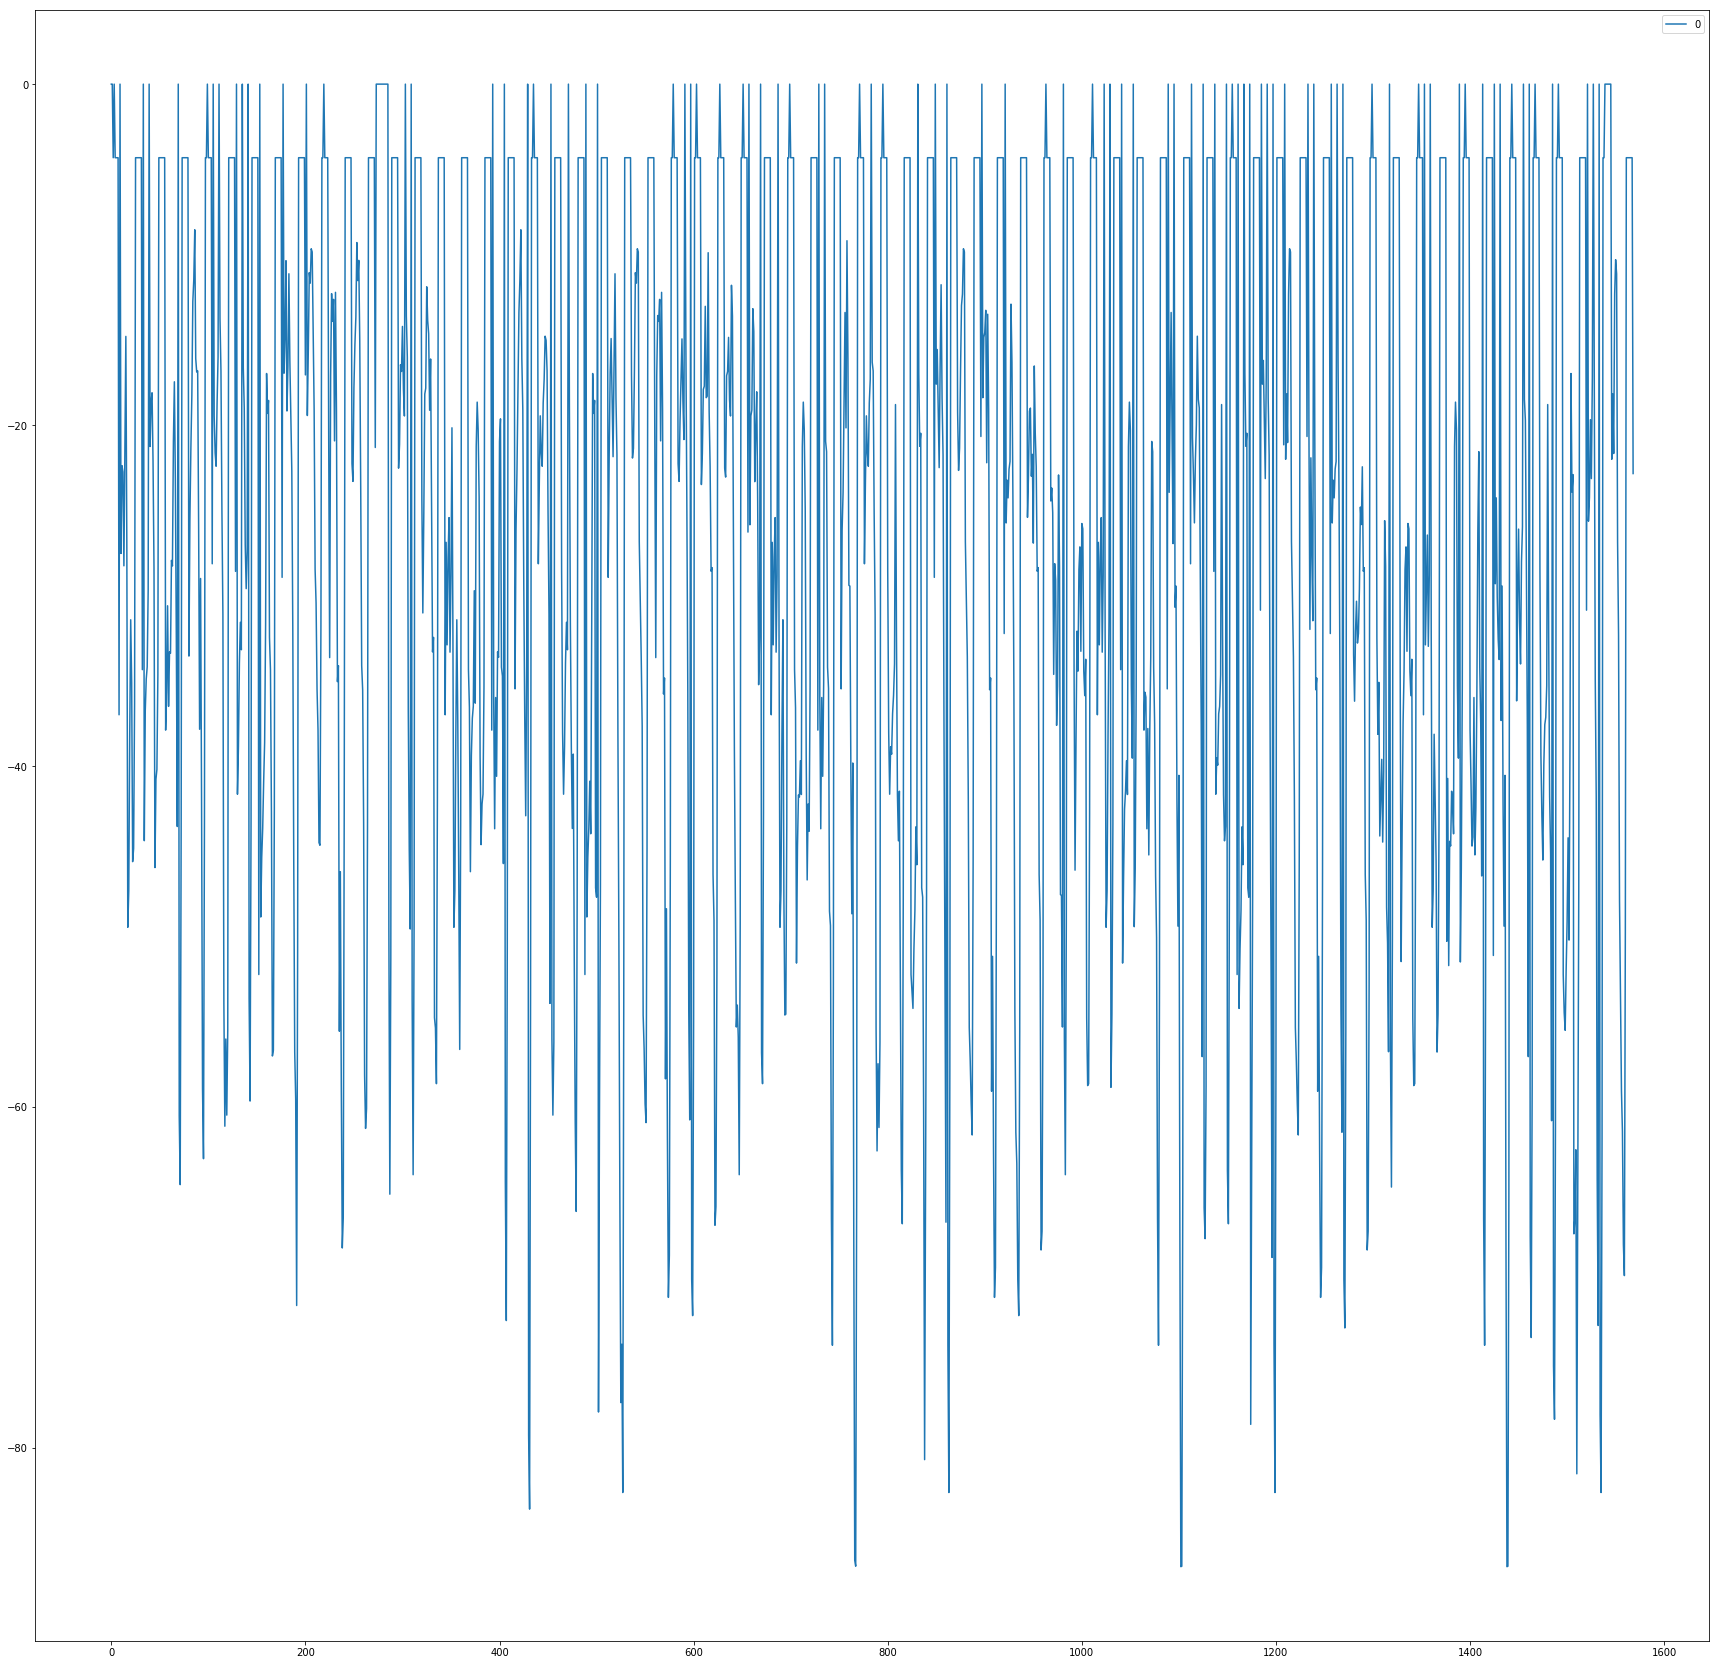

In [14]:
ts = pd.DataFrame(usage_data[10,:])
ts.plot(figsize=(30,30))

Okay, also very similar. Let's see if there is some form of correlation in the overall time series. First I'll create a completely random plot to show what no correlation look like and then we can see the lag_plot

In [ ]:
game_data = next(GamesIterator())
usage_data = game_data[1]

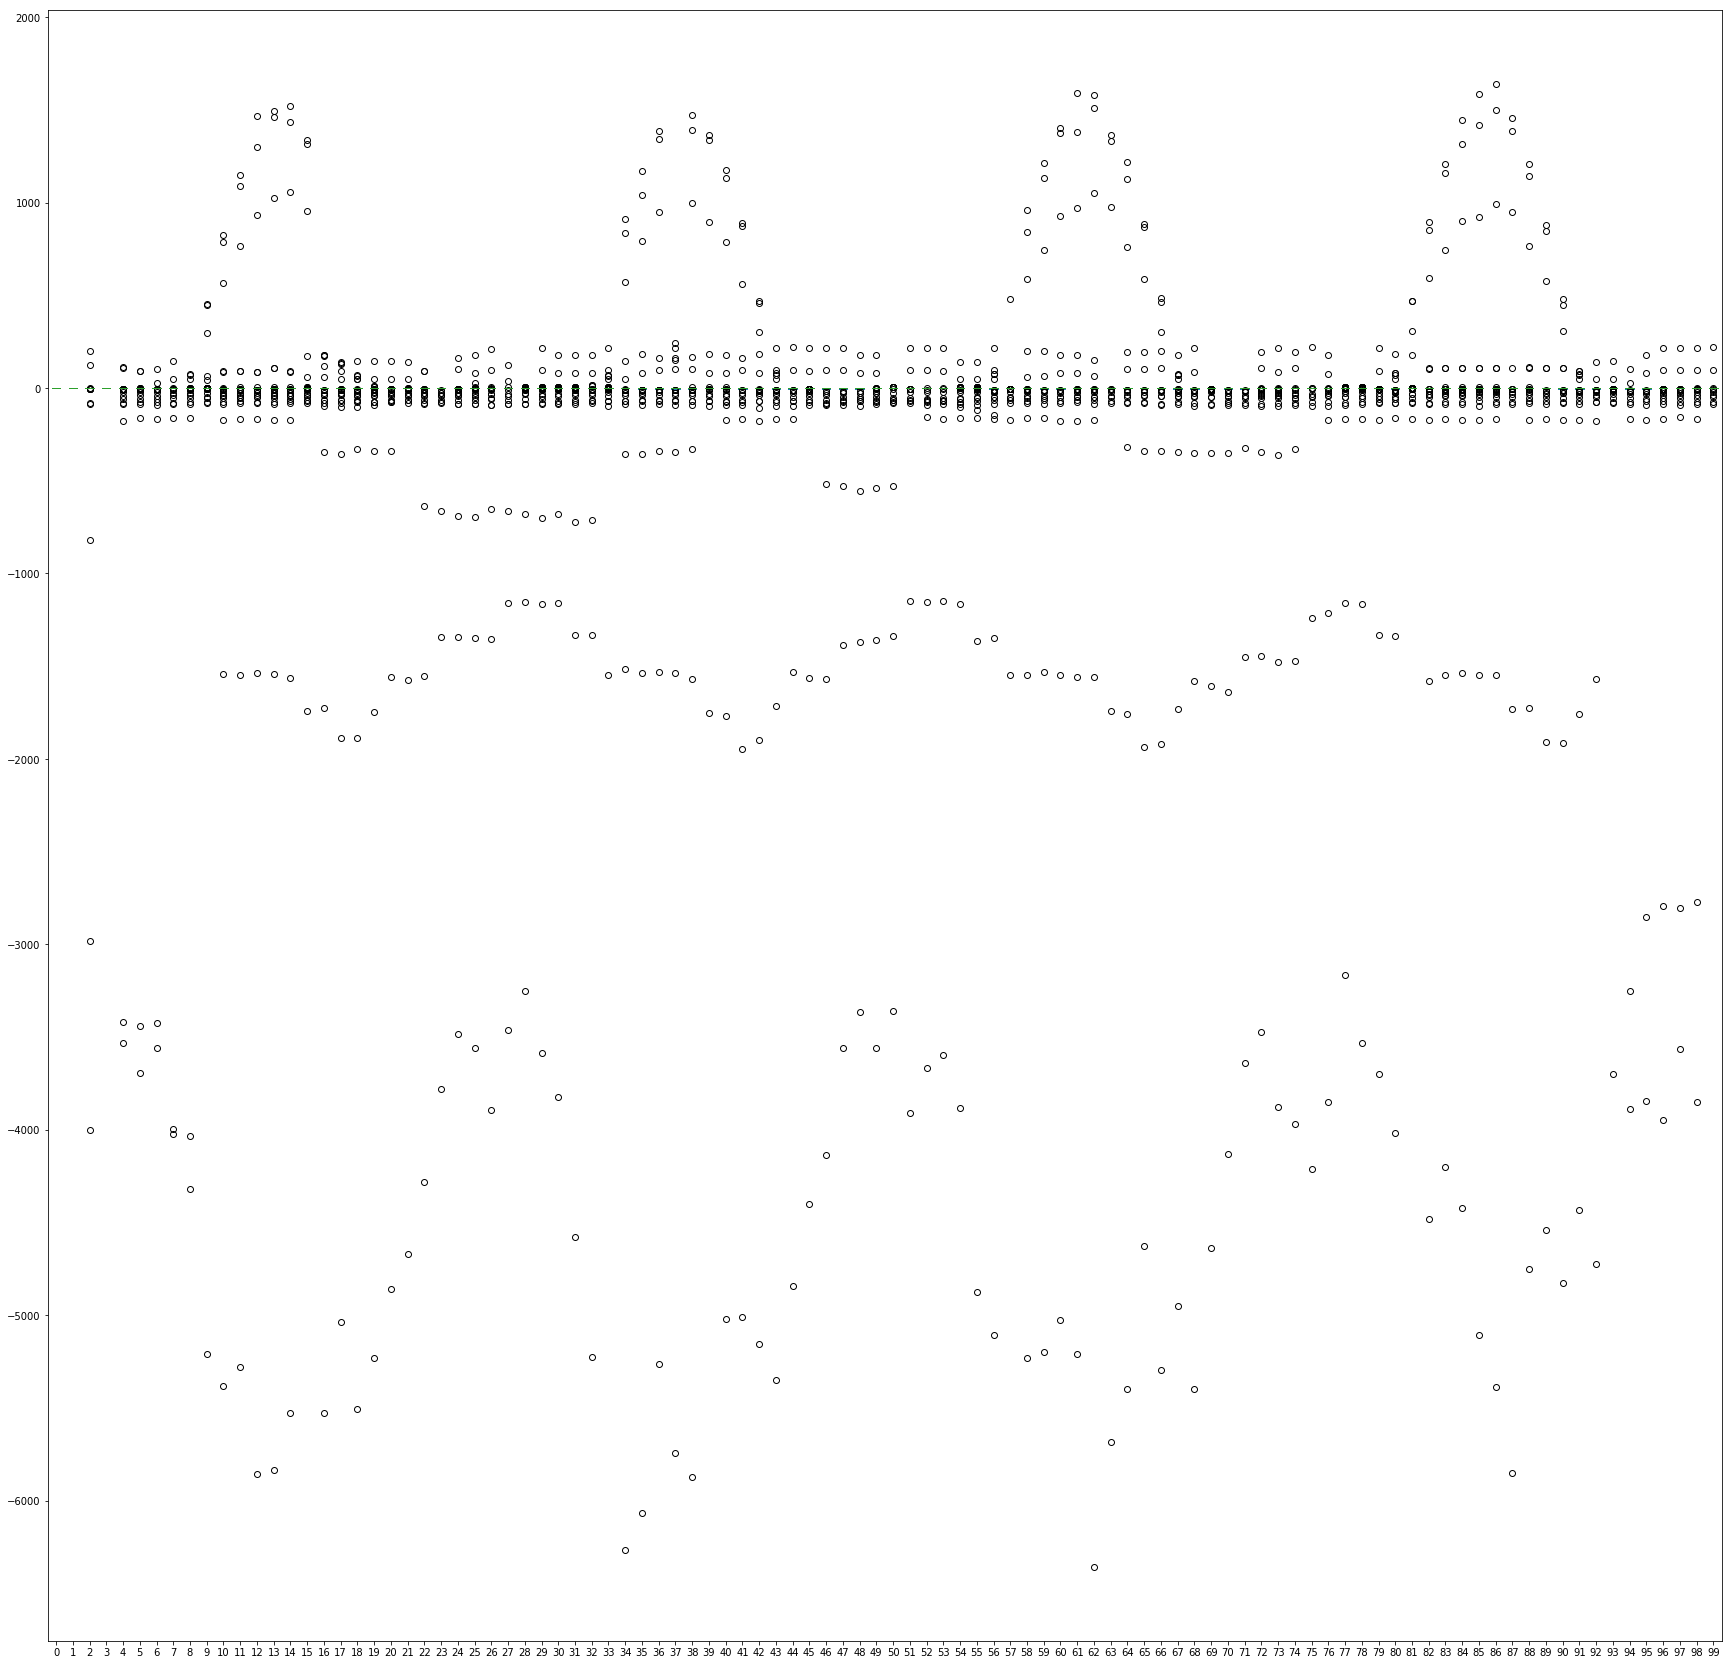

In [11]:
#_data = preprocessing.scale(usage_data[:,0:10])
#_data = usage_data[:,0:10]
_data = np.zeros(usage_data.shape)
for i, usr in enumerate(usage_data):
    for j, measure in enumerate(usr):    
        _data[i][j] = float(usage_data[i][j]) / float(game_data[0][i][j][0])
df = pd.DataFrame(_data[0:96,0:100])
df.plot.box(figsize=(30,30))

Interesting to see here is clearly the structure of outliers while the other (i.e. the core customer amount) isn't visible. It is clear that during peaks of productions (small bumps up top) 

In [13]:
lag_plot = pd.plotting.lag_plot

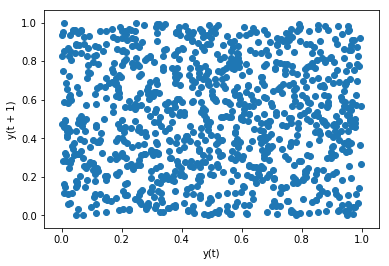

In [14]:
plt.figure()
lag_plot(pd.Series(np.random.rand(1000)))

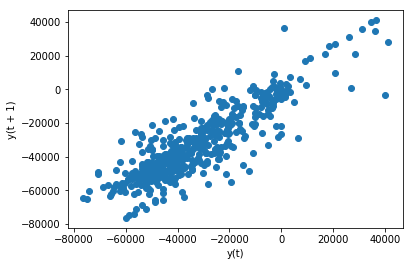

In [15]:
plt.figure()
lag_plot(pd.Series(summed_data))

Clearly this is not random. There is a correlation that we can learn. Okay enough playing for now, let's get learning with a network

## The Model

Using Keras and running through each game before repeating


To see if I'm actually making any progress on the forecasting I'll start "low" and then slowly add more complexity. So to start: An LSTM that forecasts the customer usage pattern simply on their previous consume data. No multi dim input, just on previous usage. Let's get started. 

The model is taken from [https://www.youtube.com/watch?v=ftMq5ps503w](https://www.youtube.com/watch?v=ftMq5ps503w)



In [16]:
SEQUENCE_LENGTH = 168 #one week sequences because that's a probable range for patterns
model = Sequential()
def learn_on_usage_only():
    x_train = [] #sequences
    y_train = [] #last entry of sequences
    x_test  = [] #test sequences
    y_test  = [] #test last entry
    game = next(GamesIterator())
    for customer in game[1]:
        #print(customer)
        sequences = pphelper.make_sequences(customer, SEQUENCE_LENGTH, True)
        _train    = pphelper.make_train_data(sequences)
        
        x_train.extend(_train[0])
        y_train.extend(_train[1])
        x_test. extend(_train[2])
        y_test. extend(_train[3])
        
        
    #all customers turned into sequences
    return np.array([x_train, y_train, x_test, y_test])

#running this creates a ton of chains but really that's not what we want because it's super slow and not scalable. 
#X_train, y_train, X_test, y_test = learn_on_usage_only()

getting /home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/data/consume/game9training.pickle


/home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/util/preprocessing.py:47: RuntimeWarning: invalid value encountered in double_scalars
  normalised_window = [(p / base - 1) for p in window]
/home/pascalwhoop/Documents/Code/University/powerTAC/python-agent/util/preprocessing.py:47: RuntimeWarning: divide by zero encountered in double_scalars
  normalised_window = [(p / base - 1) for p in window]


In [17]:
X_train[1].shape

(168, 1)

In [18]:
    
#Step 2 Build Model
model = Sequential()

model.add(CuDNNLSTM(
    input_shape=(None, 1),
    units=SEQUENCE_LENGTH,
    return_sequences=True))
model.add(Dropout(0.2))

model.add(CuDNNLSTM(
    units=100,
    return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(
    units=1))
model.add(Activation('linear'))

start = time.time()
model.compile(loss='mse', optimizer='rmsprop')
print ('compilation time : ', time.time() - start)

compilation time :  0.010336160659790039


In [1]:
#tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph', 
#                                         histogram_freq=1, 
#                                         batch_size=32,
#                                         write_graph=True, 
#                                         write_images=True)

#Step 3 Train the model
#model.fit(
#    np.array(X_train)[0:5000],
#    np.array(y_train)[0:5000],
#    batch_size=1,
#    epochs=100,
#    validation_split=0.05,
#    callbacks=[tbCallBack])

In [2]:
#Step 4 - Plot the predictions!
#predictions = pphelper.predict_sequences_multiple(model, X_test[100], SEQUENCE_LENGTH, 24)
#pphelper.plot_results_multiple(predictions, y_test[100], 50)

### Clean pipeline try number 2

Alright. What's needed is a pipeline as such:

1. iterate over games
    1. Iterate over customers
        - train on customer N times
        - generate sequences from customer using [TimeseriesGenerator](https://keras.io/preprocessing/sequence/#timeseriesgenerator)
    2. Evaluate Performance on test set


For the sequences, a function is needed that generates a Sequence from a customers Timeseries Data
        
    

In [13]:
def run_full_learning():
    for game in GamesIterator():
        pass

,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
,
